In [1]:
import findspark
findspark.init('C:\spark\spark-2.2.1-bin-hadoop2.7')

import numpy as np
import pandas as pd

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import udf
from pyspark.sql import functions

from bs4 import BeautifulSoup

from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline

import datetime

In [2]:
sc = SparkContext().getOrCreate()
spark = SparkSession.builder.appName('comment topic modeling').getOrCreate()
# sc.stop()
# spark.stop()

In [3]:
inputloc = "C:/Users/LunaS/Desktop/2018-01/CMPT 733/project/SOCC/raw/gnm_comments.csv"
schema = StructType([
    StructField('article_id', IntegerType(), False),
    StructField('comment_counter', StringType(), False),
    StructField('comment_author', StringType(), False),
    StructField('timestamp', FloatType(), False),
    StructField('post_time', StringType(), False),
    StructField('comment_text', StringType(), False),
    StructField('TotalVotes', FloatType(), False),
    StructField('posVotes', FloatType(), False),
    StructField('negVotes', FloatType(), False),
    StructField('vote', StringType(), False),
    StructField('reactions', StringType(), False),
    StructField('replies', StringType(), False),
    StructField('comment_id', FloatType(), False),    
    StructField('parentID', FloatType(), False),
    StructField('threadID', FloatType(), False),
    StructField('streamId', FloatType(), False),
    StructField('edited', BooleanType(), False),
    StructField('isModerator', BooleanType(), False),
    StructField('highlightGroups', StringType(), False),
    StructField('moderatorEdit', StringType(), False),
    StructField('descendantsCount', StringType(), False),
    StructField('threadTimestamp', StringType(), False),
    StructField('flagCount', StringType(), False),
    StructField('sender_isSelf', StringType(), False),
    StructField('sender_loginProvider', StringType(), False),
    StructField('data_type', StringType(), False),
    StructField('is_empty', StringType(), False),
    StructField('status', StringType(), False),

])
df = spark.read.csv(inputloc, header="true", schema = schema)

In [4]:
data = df.select('article_id', 'comment_author', 'timestamp', 'comment_text', 'TotalVotes', 'posVotes', 'negVotes')
data.show()

+----------+--------------+-------------+--------------------+----------+--------+--------+
|article_id|comment_author|    timestamp|        comment_text|TotalVotes|posVotes|negVotes|
+----------+--------------+-------------+--------------------+----------+--------+--------+
|  10012655|     modoglobe|1.36422123E12|I think the progr...|       0.0|    null|    null|
|  10012655|      stueegee|1.36416657E12|This is just 'off...|       0.0|    null|    null|
|  10012655|       EJS1018|1.36396459E12|How do you spell ...|       0.0|    null|    null|
|  10012655|     Seedy How|1.36395817E12|TFWs have a place...|       0.0|    null|    null|
|  10012655|       Roger_M|1.36391963E12|Why should tempor...|       0.0|    null|    null|
|  10012655|   Rick Taves1|1.36391937E12|No sense playing ...|       0.0|    null|    null|
|  10012655|        OldCdn| 1.3639005E12|There will never ...|       0.0|    null|    null|
|  10012655|     Seedy How|1.36395791E12|TFWs have a place...|       0.0|    nul

In [5]:
def clean_comment(comment):
    
    # remove html tags
    soup = BeautifulSoup(comment)
    comment = soup.get_text()
    
    # tokenize
    tokenized = word_tokenize(comment)
    
    # remove punctuation
    tokens = [word.lower() for word in tokenized if word.isalpha()]
    
    # remove stop words
    stop_words = stopwords.words('english')
    stop_words = set(stopwords.words('english'))
    words = [w for w in tokens if not w in stop_words]
    
    # stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(w) for w in words if not w in stop_words]
    
    return words

In [7]:
udf_clean_comment = udf(clean_comment, StringType())
data = data.withColumn("comment_text", udf_clean_comment(data["comment_text"]))

In [ ]:
data.write.csv('clean_comment', header=True)

### EDA

### votes

In [9]:
def draw_pos_neg(df, N):
    df = df.groupBy('comment_author') \
                            .agg(functions.sum('posVotes'), functions.sum('negVotes'))
    
    df = df.withColumn('pos_neg', df['sum(posVotes)'] + df['sum(negVotes)']) \
                        .orderBy('pos_neg', ascending = False)
    tops = df.limit(N)

    comment_authors = tops.select("comment_author").rdd.flatMap(lambda x: x).collect()
    posVotes = tops.select("sum(posVotes)").rdd.flatMap(lambda x: x).collect()
    negVotes = tops.select("sum(negVotes)").rdd.flatMap(lambda x: x).collect()
    
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 20})
    ind = np.arange(N)
    width = 0.35

    p1 = plt.bar(ind, posVotes, width, color = 'lightgreen')
    p2 = plt.bar(ind, negVotes, width, color = 'salmon', bottom=posVotes)

    plt.ylabel('total votes')
    plt.title('the total votes that comment authors received')
    plt.xticks(ind, comment_authors, rotation = 80)
    plt.legend((p1[0], p2[0]), ('posVotes', 'negVotes'))

    plt.show()

### total votes over all years

In [10]:
comment_all = data

In [13]:
comment_all

DataFrame[article_id: int, comment_author: string, timestamp: float, comment_text: string, TotalVotes: float, posVotes: float, negVotes: float]

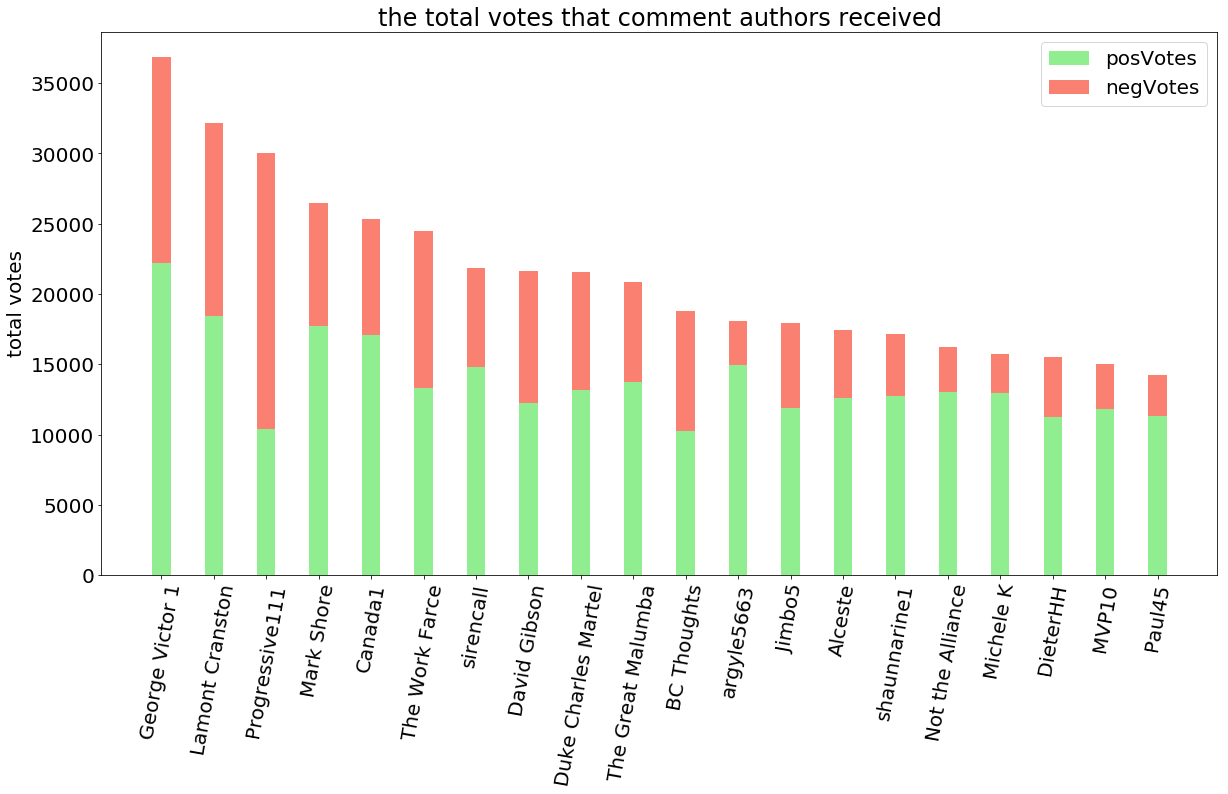

In [11]:
draw_pos_neg(comment_all, 20)

### split by years

In [14]:
def convert_to_datetime(timestamp):
    datetime = str(pd.to_datetime(timestamp, unit='ms'))
    year = datetime[:4]
    return year
    
udf_convert_to_datetime = udf(convert_to_datetime, StringType())
comment_year_df = data.withColumn("year", udf_convert_to_datetime(comment_all["timestamp"]))

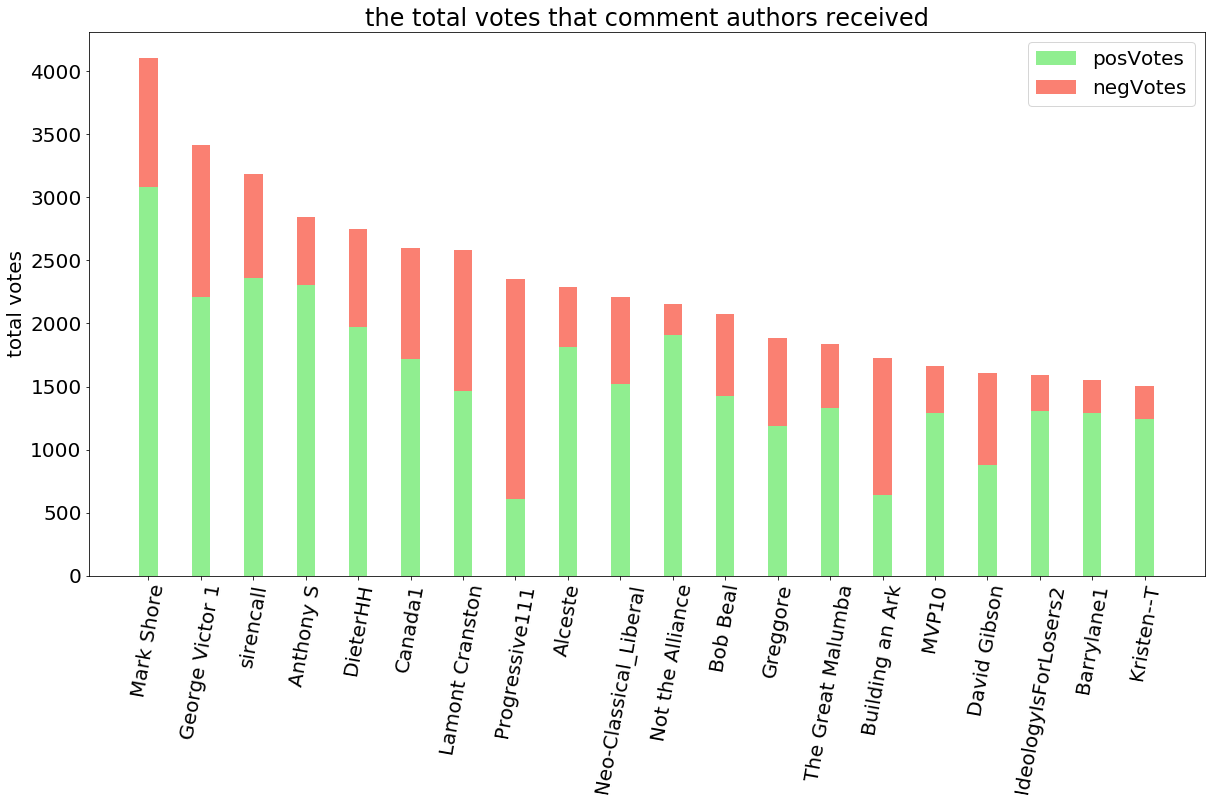

In [15]:
comment_year_2013 = comment_year_df.filter(comment_year_df['year'] == 2013)
draw_pos_neg(comment_year_2013, 20)

### authors

In [16]:
years = set(comment_year_df.select("year").rdd.flatMap(lambda x: x).collect())

In [17]:
years

{'2013', '2014', '2015', '2016', 'None'}

In [18]:
years = {2013, 2014, 2015, 2016}

In [19]:
def generate_top_authors(df, year, N):
    df = df.filter(df['year'] == year)
    df = df.groupBy('comment_author') \
                            .agg(functions.sum('posVotes'), functions.sum('negVotes'))
    
    df = df.withColumn('pos_neg', df['sum(posVotes)'] + df['sum(negVotes)']) \
                        .orderBy('pos_neg', ascending = False)
    tops = df.limit(N)

    comment_authors = tops.select("comment_author").rdd.flatMap(lambda x: x).collect()
    return set(comment_authors)

In [ ]:
top_authors = []
for year in years:
    top_author = generate_top_authors(comment_year_df, year, 20)
    top_authors.append(top_author)

In [ ]:
u = set.intersection(*top_authors)

In [ ]:
authors_dict = {}
for authors in top_authors:
    for author in authors:
        if not author in authors_dict:
            authors_dict[author] = 1
        else:
            authors_dict[author] += 1

In [81]:
sorted(authors_dict.items(), key=lambda x: x[1], reverse  = True)

[('Progressive111', 4),
 ('Mark Shore', 4),
 ('sirencall', 4),
 ('George Victor 1', 4),
 ('Lamont Cranston', 4),
 ('David Gibson', 4),
 ('The Work Farce', 3),
 ('shaunnarine1', 3),
 ('Jimbo5', 3),
 ('MVP10', 3),
 ('Canada1', 3),
 ('Alceste', 2),
 ('Michele K', 2),
 ('argyle5663', 2),
 ('BC Thoughts', 2),
 ('The Great Malumba', 2),
 ('Not the Alliance', 2),
 ('DieterHH', 2),
 ('Citizen 1', 1),
 ('Scrimbro 2 - Electric Boogaloo', 1),
 ('IanC2222', 1),
 ('Matt Hughes', 1),
 ('The Last Truthbender', 1),
 ('trevor smith-brown', 1),
 ('Paul45', 1),
 ('Stephen Saines', 1),
 ('monkey121', 1),
 ('William_Brodie', 1),
 ('thode', 1),
 ('Dominion Lad', 1),
 ('FAR2NICE', 1),
 ('Ursula Seawitch', 1),
 ('Billwigg', 1),
 ('staph', 1),
 ('Linda Cole', 1),
 ('MyOpinion8', 1),
 ('SusanEwart', 1),
 ('Moe Unting', 1),
 ('RMcMurphy', 1),
 ('Saynomore', 1),
 ('M_G', 1),
 ('TalkSpot', 1),
 ('Deano from Calgary', 1),
 ('Globe and Mail commenter C650A7DFD424F9FEE9446956B365AB96C8EA8CE1544D5579A34E0F8B7F52EAEE',